In [27]:
import numpy as np
import matplotlib.pyplot as plt
from utils import journal_figure
from scipy.stats import spearmanr
from utils import spearman_ci_boot, calculate_i1, split_half_reliability
import json
import pandas as pd
from scipy.signal import savgol_filter


In [28]:
selected_indices = [0, 2, 22, 25, 41, 44, 63, 68, 81, 85, 101, 120, 122, 140, 142, 161, 180, 187]
selected_indices_v2 = [8, 18, 24, 31, 46, 54, 70, 76, 86, 87, 102, 103, 105, 123, 130, 143, 144, 163, 172, 173, 191, 199]
all_selected_indices = list(sorted(selected_indices + selected_indices_v2))

In [29]:
human_behavior_40 = pd.read_csv("./psychophysics/orig_human_data.csv")
i1_humans_40 = calculate_i1(human_behavior_40, key="image_num")


reliability_humans_40 = []
for rep in range(50):
    r, _, _ = split_half_reliability(human_behavior_40, key="image_num")
    reliability_humans_40.append(r)

reliability_humans_40 = np.array(reliability_humans_40)

In [30]:
def fisher_transform(r):
    z = 0.5 * np.log((1+r)/(1-r+ 1e-5))
    return z

In [31]:
i1_humans_40_ = fisher_transform(i1_humans_40)

In [32]:
consistencies_bubbles = []
consistencies_bubbles_el = []
consistencies_bubbles_eh = []
reliabilities_bubbles = np.zeros((6, 50))+np.nan
accuracies_bubbles = []
accuracies_bubbles_std = []
for v, bubbles_v in enumerate([5, 10, 20, 30, 40, 50]):
    human_behavior_bubbles = pd.read_csv(f"./psychophysics/bubbles/bubbleTest{bubbles_v}_human_data.csv")
    i1_human_behavior_bubbles = calculate_i1(human_behavior_bubbles, key="image_num")

    i1_human_behavior_bubbles_ = fisher_transform(i1_human_behavior_bubbles)

    consistency_human_behavior_bubbles, el, eh = spearman_ci_boot(i1_human_behavior_bubbles_, i1_humans_40_)
    consistencies_bubbles.append(consistency_human_behavior_bubbles)
    consistencies_bubbles_el.append(el)
    consistencies_bubbles_eh.append(eh)
    accuracies_bubbles.append(i1_human_behavior_bubbles.mean())
    accuracies_bubbles_std.append(i1_human_behavior_bubbles.std())

    for rep in range(50):
        r, _, _ = split_half_reliability(human_behavior_bubbles, key="image_num")
        reliabilities_bubbles[v, rep] = r

In [33]:
from PIL import Image

all_images_object_only = np.zeros((40, 224, 224, 3))
for i, s in enumerate(all_selected_indices):
    im = Image.open(f"./object_only/im{s}.png").resize((224, 224), Image.BILINEAR)
    im = np.array(im)
    
    all_images_object_only[i] = im
    
percentile_object_only_all = []
for i, s in enumerate(all_selected_indices):
    greys = (all_images_object_only[i].mean(axis=2) == 127).sum()
    percentile_object_only = greys/(224*224)*100
    percentile_object_only_all.append(percentile_object_only)

In [34]:
human_behavior_object_only = pd.read_csv(f"./psychophysics/object_only_human_data.csv")
i1_human_behavior_object_only = calculate_i1(human_behavior_object_only, key="image_num")
i1_human_behavior_object_only_ = fisher_transform(i1_human_behavior_object_only)
consistency_human_behavior_object_only, consistency_human_behavior_object_only_el, consistency_human_behavior_object_only_eh = spearman_ci_boot(i1_human_behavior_object_only, i1_humans_40_)
accuracy_human_behavior_object_only = i1_human_behavior_object_only.mean()
accuracy_human_behavior_object_only_std = i1_human_behavior_object_only.std()

reliabilities_object_only = []
for rep in range(50):
    r, _, _ = split_half_reliability(human_behavior_object_only, key="image_num")
    reliabilities_object_only.append(r)

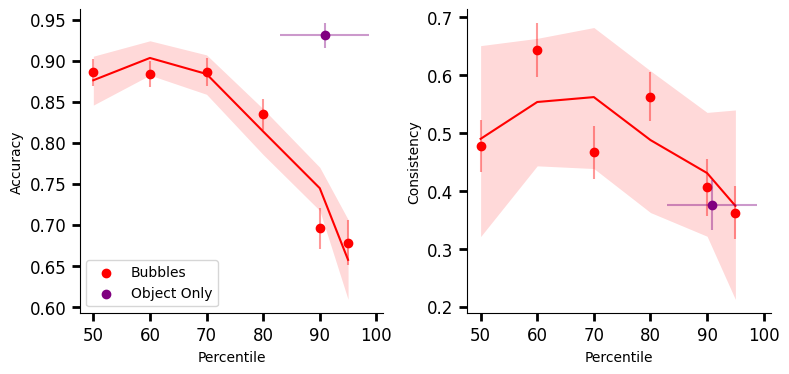

In [35]:

plt.figure(figsize=(8,4))
# ----------------------- RED (bubbles) -----------------------
x = np.array([100 - v for v in [5, 10, 20, 30, 40, 50]], float)

# left: Accuracy
plt.subplot(1,2,1)
for v, bubbles_v in enumerate([5, 10, 20, 30, 40, 50]):
    plt.scatter(100-bubbles_v, accuracies_bubbles[v], color="red", label="Bubbles" if v==0 else None)
    plt.errorbar(100-bubbles_v, accuracies_bubbles[v],
                 yerr=accuracies_bubbles_std[v]/np.sqrt(40),
                 color="red", alpha=0.4)

y = np.array(accuracies_bubbles)

yerr = np.array(accuracies_bubbles_std)/np.sqrt(40)

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="red")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="red", alpha=0.15, linewidth=0)

# right: Consistency
plt.subplot(1,2,2)
for v, bubbles_v in enumerate([5, 10, 20, 30, 40, 50]):
    plt.scatter(100-bubbles_v, consistencies_bubbles[v]/np.sqrt(np.nanmean(reliabilities_bubbles[v]) * np.nanmean(reliability_humans_40)), color="red")
    plt.errorbar(100-bubbles_v, consistencies_bubbles[v]/np.sqrt(np.nanmean(reliabilities_bubbles[v]) * np.nanmean(reliability_humans_40)),
                 yerr=((consistencies_bubbles_el[v]+consistencies_bubbles_eh[v])/2)/np.sqrt(40),
                 color="red", alpha=0.4)

x = 100 - np.array([5, 10, 20, 30, 40, 50])
y = consistencies_bubbles / np.sqrt(np.nanmean(reliabilities_bubbles) *
                                    np.nanmean(reliability_humans_40))

yerr = (np.array(consistencies_bubbles_el) + np.array(consistencies_bubbles_eh) / 2) / np.sqrt(40)
yerr = yerr / np.sqrt(np.nanmean(reliabilities_bubbles) * np.nanmean(reliability_humans_40))

order = np.argsort(x)
x, y, yerr = x[order], y[order], yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="red")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="red", alpha=0.15, linewidth=0)

# ----------------------- Purple point (no fit requested) -----------------------
plt.subplot(1,2,1)
plt.scatter(np.array(percentile_object_only_all).mean(),
            accuracy_human_behavior_object_only, color="purple", label="Object Only")
plt.errorbar(np.array(percentile_object_only_all).mean(),
             accuracy_human_behavior_object_only,
             xerr=np.array(percentile_object_only_all).std(),
             yerr=accuracy_human_behavior_object_only_std/np.sqrt(40),
             color="purple", alpha=0.4)

plt.subplot(1,2,2)
plt.scatter(np.array(percentile_object_only_all).mean(),
            consistency_human_behavior_object_only/np.sqrt(np.nanmean(np.array(reliabilities_object_only)) * np.nanmean(reliability_humans_40)), color="purple")
plt.errorbar(np.array(percentile_object_only_all).mean(),
             consistency_human_behavior_object_only/np.sqrt(np.nanmean(np.array(reliabilities_object_only)) * np.nanmean(reliability_humans_40)),
             xerr=np.array(percentile_object_only_all).std(),
             yerr=((consistency_human_behavior_object_only_eh
                    + consistency_human_behavior_object_only_el)/2)/np.sqrt(40),
             color="purple", alpha=0.4)

# Labels / styling
plt.subplot(1,2,1)
plt.xlabel('Percentile')
plt.ylabel('Accuracy')
plt.legend()
journal_figure()

plt.subplot(1,2,2)
plt.xlabel('Percentile')
plt.ylabel('Consistency')
journal_figure()

plt.tight_layout()

In [36]:
xb_blue = np.array([50, 60, 70, 80, 90, 95], float)
yblue_accs = np.zeros((6))
yerr_blue_acc = np.zeros((6))
yblue_corrs = np.zeros((6))
yerr_blue_corr = np.zeros((6))
for idx, x in enumerate(xb_blue):

    csv = pd.read_csv(f"./psychophysics/human_data_convnext/pemi_convnext_prctile_human_dataconvnext_NoiseTunnel_Saliency_{int(x)}.csv")
    i1 = calculate_i1(csv, key="image_num")
    i1_ = fisher_transform(i1)
    consistency, el, eh = spearman_ci_boot(i1_, i1_humans_40_)
    reliabilities = []
    for r in range(10):
        reliability, _, _ = split_half_reliability(csv, key="image_num")
        reliabilities.append(reliability)
    accuracv = i1.mean()
    accuracv_std = i1.std()
    yblue_accs[idx] =accuracv
    yerr_blue_acc[idx] = accuracv_std/np.sqrt(40)
    yblue_corrs[idx] = consistency/np.sqrt(np.mean(reliabilities)*np.mean(reliability_humans_40))
    yerr_blue_corr[idx] = ((eh+el)/2)/np.sqrt(40)

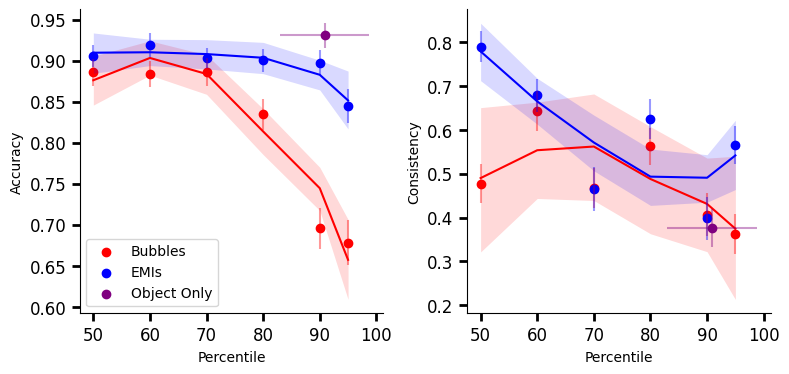

In [37]:

plt.figure(figsize=(8,4))
# ----------------------- RED (bubbles) -----------------------
x = np.array([100 - v for v in [5, 10, 20, 30, 40, 50]], float)

# left: Accuracy
plt.subplot(1,2,1)
for v, bubbles_v in enumerate([5, 10, 20, 30, 40, 50]):
    plt.scatter(100-bubbles_v, accuracies_bubbles[v], color="red", label="Bubbles" if v==0 else None)
    plt.errorbar(100-bubbles_v, accuracies_bubbles[v],
                 yerr=accuracies_bubbles_std[v]/np.sqrt(40),
                 color="red", alpha=0.4)

y = np.array(accuracies_bubbles)

yerr = np.array(accuracies_bubbles_std)/np.sqrt(40)

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="red")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="red", alpha=0.15, linewidth=0)

# right: Consistency
plt.subplot(1,2,2)
for v, bubbles_v in enumerate([5, 10, 20, 30, 40, 50]):
    plt.scatter(100-bubbles_v, consistencies_bubbles[v]/np.sqrt(np.nanmean(reliabilities_bubbles[v]) * np.nanmean(reliability_humans_40)), color="red")
    plt.errorbar(100-bubbles_v, consistencies_bubbles[v]/np.sqrt(np.nanmean(reliabilities_bubbles[v]) * np.nanmean(reliability_humans_40)),
                 yerr=((consistencies_bubbles_el[v]+consistencies_bubbles_eh[v])/2)/np.sqrt(40),
                 color="red", alpha=0.4)

x = 100 - np.array([5, 10, 20, 30, 40, 50])
y = consistencies_bubbles / np.sqrt(np.nanmean(reliabilities_bubbles) *
                                    np.nanmean(reliability_humans_40))

yerr = (np.array(consistencies_bubbles_el) + np.array(consistencies_bubbles_eh) / 2) / np.sqrt(40)
yerr = yerr / np.sqrt(np.nanmean(reliabilities_bubbles) * np.nanmean(reliability_humans_40))

order = np.argsort(x)
x, y, yerr = x[order], y[order], yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="red")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="red", alpha=0.15, linewidth=0)

# ----------------------- BLUE (percentiles) -----------------------

# # left: Accuracy
plt.subplot(1,2,1)

plt.scatter(xb_blue, yblue_accs, color="blue", label="EMIs")
plt.errorbar(xb_blue, yblue_accs,
                yerr=yerr_blue_acc,
                color="blue", alpha=0.4, linestyle="None")

x = xb_blue
y = yblue_accs
yerr = yerr_blue_acc

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="blue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="blue", alpha=0.15, linewidth=0)

plt.subplot(1,2,2)

plt.scatter(xb_blue, yblue_corrs, color="blue")
plt.errorbar(xb_blue, yblue_corrs,
                yerr=yerr_blue_corr,
                color="blue", alpha=0.4, linestyle="None")

x = xb_blue
y = yblue_corrs

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = yerr_blue_corr

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="blue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="blue", alpha=0.15, linewidth=0)


# ----------------------- PURPLE point (no fit requested) -----------------------
plt.subplot(1,2,1)
plt.scatter(np.array(percentile_object_only_all).mean(),
            accuracy_human_behavior_object_only, color="purple", label="Object Only")
plt.errorbar(np.array(percentile_object_only_all).mean(),
             accuracy_human_behavior_object_only,
             xerr=np.array(percentile_object_only_all).std(),
             yerr=accuracy_human_behavior_object_only_std/np.sqrt(40),
             color="purple", alpha=0.4)

plt.subplot(1,2,2)
plt.scatter(np.array(percentile_object_only_all).mean(),
            consistency_human_behavior_object_only/np.sqrt(np.nanmean(np.array(reliabilities_object_only)) * np.nanmean(reliability_humans_40)), color="purple")
plt.errorbar(np.array(percentile_object_only_all).mean(),
             consistency_human_behavior_object_only/np.sqrt(np.nanmean(np.array(reliabilities_object_only)) * np.nanmean(reliability_humans_40)),
             xerr=np.array(percentile_object_only_all).std(),
             yerr=((consistency_human_behavior_object_only_eh
                    + consistency_human_behavior_object_only_el)/2)/np.sqrt(40),
             color="purple", alpha=0.4)

# Labels / styling
plt.subplot(1,2,1)
plt.xlabel('Percentile')
plt.ylabel('Accuracy')
plt.legend()
journal_figure()

plt.subplot(1,2,2)
plt.xlabel('Percentile')
plt.ylabel('Consistency')
journal_figure()

plt.tight_layout()


In [38]:
xb_blue = np.array([50, 60, 70, 80, 90, 95], float)
yblue_accs_worst = np.zeros((6))
yerr_blue_acc_worst = np.zeros((6))
yblue_corrs_worst = np.zeros((6))
yerr_blue_corr_worst = np.zeros((6))
for idx, x in enumerate(xb_blue):

    csv = pd.read_csv(f"./psychophysics/human_data_convnext/pemi_convnext_prctile_human_dataconvnext_Deconvolution_{int(x)}.csv")
    i1 = calculate_i1(csv, key="image_num")
    consistency, el, eh = spearman_ci_boot(i1, i1_humans_40_)
    reliabilities = []
    for r in range(10):
        reliability, _, _ = split_half_reliability(csv, key="image_num")
        reliabilities.append(reliability)
    accuracv = i1.mean()
    accuracv_std = i1.std()
    yblue_accs_worst[idx] =accuracv
    yerr_blue_acc_worst[idx] = accuracv_std/np.sqrt(40)
    yblue_corrs_worst[idx] = consistency/np.sqrt(np.mean(reliabilities)*np.mean(reliability_humans_40))
    yerr_blue_corr_worst[idx] = ((eh+el)/2)/np.sqrt(40)

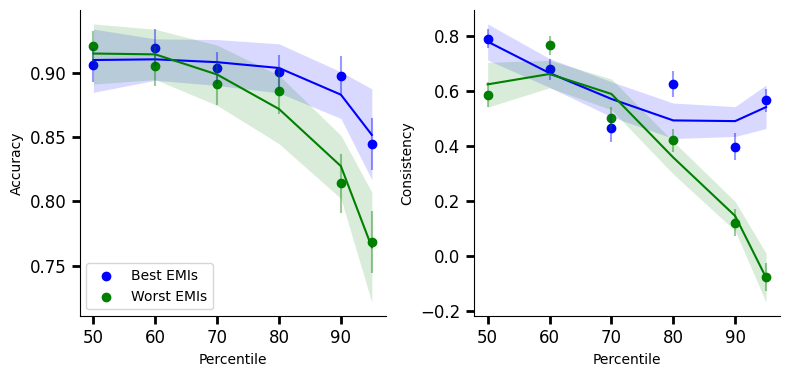

In [39]:

plt.figure(figsize=(8,4))

# ----------------------- BLUE (percentiles) -----------------------
# left: Accuracy
plt.subplot(1,2,1)

plt.scatter(xb_blue, yblue_accs, color="blue", label="Best EMIs")
plt.errorbar(xb_blue, yblue_accs,
                yerr=yerr_blue_acc,
                color="blue", alpha=0.4, linestyle="None")

x = xb_blue
y = yblue_accs

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = yerr_blue_acc

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="blue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="blue", alpha=0.15, linewidth=0)

# right: Consistency (FIX: index i was wrongly using v before)
plt.subplot(1,2,2)

plt.scatter(xb_blue, yblue_corrs, color="blue")
plt.errorbar(xb_blue, yblue_corrs,
                yerr=yerr_blue_corr,
                color="blue", alpha=0.4, linestyle="None")

x = xb_blue
y = yblue_corrs

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = yerr_blue_corr

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="blue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="blue", alpha=0.15, linewidth=0)


plt.subplot(1,2,1)

plt.scatter(xb_blue, yblue_accs_worst, color="green", label="Worst EMIs")
plt.errorbar(xb_blue, yblue_accs_worst,
                yerr=yerr_blue_acc_worst,
                color="green", alpha=0.4, linestyle="None")

x = xb_blue
y = yblue_accs_worst

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = yerr_blue_acc_worst

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="green")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="green", alpha=0.15, linewidth=0)

# right: Consistency (FIX: index i was wrongly using v before)
plt.subplot(1,2,2)

plt.scatter(xb_blue, yblue_corrs_worst, color="green")
plt.errorbar(xb_blue, yblue_corrs_worst,
                yerr=yerr_blue_corr_worst,
                color="green", alpha=0.4, linestyle="None")

x = xb_blue
y = yblue_corrs_worst

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = yerr_blue_corr_worst

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="green")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="green", alpha=0.15, linewidth=0)

# Labels / styling
plt.subplot(1,2,1)
plt.xlabel('Percentile')
plt.ylabel('Accuracy')
plt.legend()
journal_figure()

plt.subplot(1,2,2)
plt.xlabel('Percentile')
plt.ylabel('Consistency')
journal_figure()

plt.tight_layout()


In [40]:
percentiles = np.array([50, 60, 70, 80, 90, 95])
accs_p = np.zeros((1, len(percentiles)))+np.nan
accs_p_err = np.zeros((1, len(percentiles)))+np.nan
corrs_p = np.zeros((1, len(percentiles)))+np.nan
corrs_p_err = np.zeros((1, len(percentiles)))+np.nan

accs_p_worst = np.zeros((1, len(percentiles)))+np.nan
accs_p_worst_err = np.zeros((1, len(percentiles)))+np.nan
corrs_p_worst = np.zeros((1, len(percentiles)))+np.nan
corrs_p_worst_err = np.zeros((1, len(percentiles)))+np.nan

# for r in range(20):
for p_idx, p in enumerate(percentiles):
    response_dir = f'../../XAI/behavioral_responses/convnext/NoiseTunnel_Saliency'
    i1_file_ref = f'{response_dir}/{p}/convnext_i1.json'
    
    with open(i1_file_ref, 'r') as f:
        i1_scores_ref = json.load(f)
    
    i1_20 = np.array(i1_scores_ref['target_pEMI'])[all_selected_indices]
    i1_20_ = fisher_transform(i1_20)

    accs_p[0,p_idx] = i1_20.mean()
    accs_p_err[0,p_idx] = i1_20.std()/np.sqrt(len(i1_20))

    corr, el, eh = spearman_ci_boot(i1_20_, i1_humans_40_)

    corrs_p[0,p_idx] = corr
    corrs_p_err[0,p_idx] = (el+eh)/2

    response_dir = f'../../XAI/behavioral_responses_v2/convnext/Deconvolution'
    i1_file_ref = f'{response_dir}/{p}/convnext_i1.json'

    with open(i1_file_ref, 'r') as f:
        i1_scores_ref = json.load(f)
    
    i1_20 = np.array(i1_scores_ref['target_pEMI'])[all_selected_indices]
    i1_20_ = fisher_transform(i1_20)

    accs_p_worst[0,p_idx] = i1_20.mean()
    accs_p_worst_err[0,p_idx] = i1_20.std()/np.sqrt(len(i1_20))

    corr, el, eh = spearman_ci_boot(i1_20_, i1_humans_40_)

    corrs_p_worst[0,p_idx] = corr
    corrs_p_worst_err[0,p_idx] = (el+eh)/2

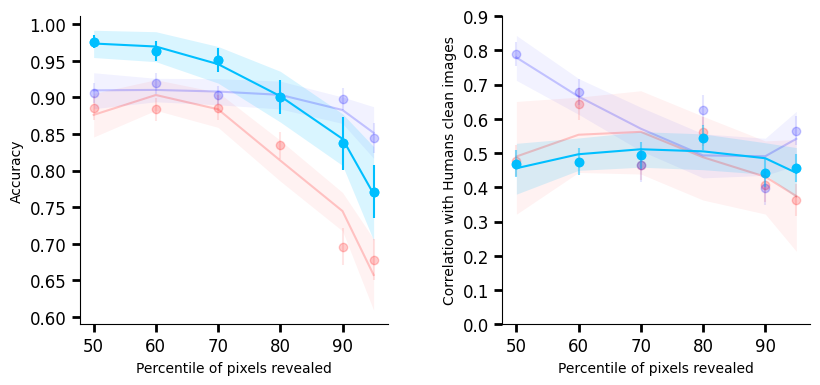

In [41]:
plt.figure(figsize=(10, 4))

# ----------------------- RED (bubbles) -----------------------
xb_red = np.array([100 - v for v in [5, 10, 20, 30, 40, 50]], float)

# left: Accuracy
plt.subplot(1,2,1)
for v, bubbles_v in enumerate([5, 10, 20, 30, 40, 50]):
    plt.scatter(100-bubbles_v, accuracies_bubbles[v], color="red", label="Bubbles" if v==0 else None, alpha=0.2)
    plt.errorbar(100-bubbles_v, accuracies_bubbles[v],
                 yerr=accuracies_bubbles_std[v]/np.sqrt(40),
                 color="red", alpha=0.1)

x = 100 - np.array([5, 10, 20, 30, 40, 50])
y = np.array(accuracies_bubbles)

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = np.array(accuracies_bubbles_std)/np.sqrt(40)

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="red", alpha=0.2)

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="red", alpha=0.05, linewidth=0)

# right: Consistency
plt.subplot(1,2,2)
for v, bubbles_v in enumerate([5, 10, 20, 30, 40, 50]):
    plt.scatter(100-bubbles_v, consistencies_bubbles[v]/np.sqrt(np.nanmean(reliabilities_bubbles[v]) * np.nanmean(reliability_humans_40)), color="red", alpha=0.2)
    plt.errorbar(100-bubbles_v, consistencies_bubbles[v]/np.sqrt(np.nanmean(reliabilities_bubbles[v]) * np.nanmean(reliability_humans_40)),
                 yerr=((consistencies_bubbles_el[v]+consistencies_bubbles_eh[v])/2)/np.sqrt(40),
                 color="red", alpha=0.1)

x = 100 - np.array([5, 10, 20, 30, 40, 50])
y = consistencies_bubbles / np.sqrt(np.nanmean(reliabilities_bubbles) *
                                    np.nanmean(reliability_humans_40))

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = (np.array(consistencies_bubbles_el) + np.array(consistencies_bubbles_eh) / 2) / np.sqrt(40)
yerr = yerr / np.sqrt(np.nanmean(reliabilities_bubbles) * np.nanmean(reliability_humans_40))

order = np.argsort(x)
x, y, yerr = x[order], y[order], yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="red", alpha=0.2)

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="red", alpha=0.05, linewidth=0)

ax = plt.subplot(1,2,1)

plt.scatter(xb_blue, yblue_accs, color="blue", label="EMIs", alpha=0.2)
plt.errorbar(xb_blue, yblue_accs,
                yerr=yerr_blue_acc,
                color="blue", alpha=0.1, linestyle="None")

x = xb_blue
y = yblue_accs

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = yerr_blue_acc

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="blue", alpha=0.2)

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="blue", alpha=0.05, linewidth=0)

ax1 = plt.subplot(1, 2, 1)
plt.scatter(percentiles, accs_p.mean(axis=0), marker='o', color='deepskyblue')
plt.errorbar(percentiles, accs_p.mean(axis=0), yerr=accs_p_err.mean(axis=0), marker='o', color='deepskyblue', linestyle="None")

x = np.array(percentiles, dtype=float)
y = accs_p.mean(axis=0)

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = accs_p_err.mean(axis=0)

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="deepskyblue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="deepskyblue", alpha=0.15, linewidth=0)

plt.xlabel("Percentile of pixels revealed")
plt.ylabel("Accuracy")
journal_figure()

ax = plt.subplot(1, 2, 2)
plt.scatter(xb_blue, yblue_corrs, color="blue", alpha=0.2)
plt.errorbar(xb_blue, yblue_corrs,
                yerr=yerr_blue_corr,
                color="blue", alpha=0.1, linestyle="None")

x = xb_blue
y = yblue_corrs

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = yerr_blue_corr

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="blue", alpha=0.2)

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="blue", alpha=0.05, linewidth=0)

plt.scatter(np.array(percentiles, dtype=float), (np.nanmean(corrs_p, axis=0)/np.sqrt(np.nanmean(reliability_humans_40))), marker='o', color='deepskyblue')
plt.errorbar(np.array(percentiles, dtype=float), (np.nanmean(corrs_p, axis=0)/np.sqrt(np.nanmean(reliability_humans_40))), yerr=np.nanmean(corrs_p_err, axis=0)/np.sqrt(40), marker='o', color='deepskyblue', linestyle="None", alpha=0.5)

x = np.array(percentiles, dtype=float)
y = (np.nanmean(corrs_p, axis=0)/np.sqrt(np.nanmean(reliability_humans_40)))

# pointwise y-errors you used for the error bars (propagate the same normalization)
yerr = np.nanmean(corrs_p_err, axis=0)/np.sqrt(40)

order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="deepskyblue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="deepskyblue", alpha=0.15, linewidth=0)

plt.xlabel("Percentile of pixels revealed")
plt.ylabel("Correlation with Humans clean images")
plt.ylim(0, 0.9)
journal_figure()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


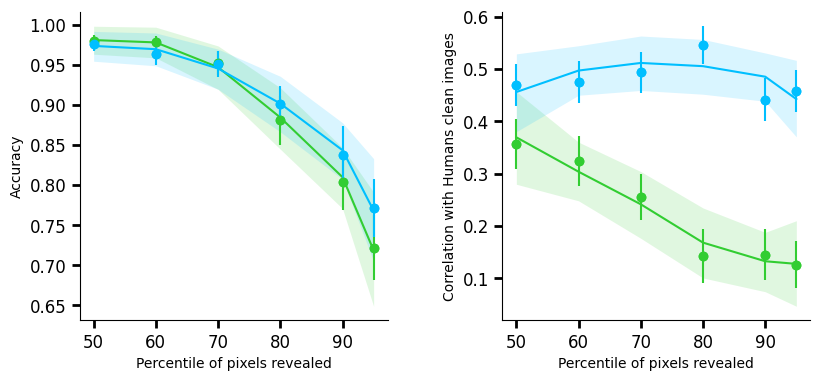

In [ ]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
x = np.array(percentiles, dtype=float)
y = accs_p_worst.mean(axis=0)
yerr = accs_p_worst_err.mean(axis=0)
plt.scatter(x, y, marker='o', color='limegreen')
plt.errorbar(x, y, yerr=yerr, marker='o', color='limegreen', linestyle="None")


order = np.argsort(x)
x = x[order]
y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="limegreen")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="limegreen", alpha=0.15, linewidth=0)

ax1 = plt.subplot(1, 2, 1)
y = accs_p.mean(axis=0)
yerr = accs_p_err.mean(axis=0)
plt.scatter(x, y, marker='o', color='deepskyblue')
plt.errorbar(x, y, yerr=yerr, marker='o', color='deepskyblue', linestyle="None")

y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="deepskyblue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="deepskyblue", alpha=0.15, linewidth=0)

plt.xlabel("Percentile of pixels revealed")
plt.ylabel("Accuracy")
journal_figure()

ax = plt.subplot(1, 2, 2)
y = (np.nanmean(corrs_p_worst, axis=0)/np.sqrt(np.nanmean(reliability_humans_40)))
yerr = (np.nanmean(corrs_p_worst_err, axis=0)/np.sqrt(40))
plt.scatter(x, y, marker='o', color='limegreen')
plt.errorbar(x, y, yerr=yerr, marker='o', color='limegreen', linestyle="None")

y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="limegreen")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="limegreen", alpha=0.15, linewidth=0)

y = (np.nanmean(corrs_p, axis=0)/np.sqrt(np.nanmean(reliability_humans_40)))
yerr = (np.nanmean(corrs_p_err, axis=0)/np.sqrt(40))
plt.scatter(x, y, marker='o', color='deepskyblue')
plt.errorbar(x, y, yerr=yerr, marker='o', color='deepskyblue', linestyle="None")

y = y[order]
yerr = yerr[order]

y_fit = savgol_filter(y, window_length=5, polyorder=2)
plt.plot(x, y_fit, color="deepskyblue")

B = 2000
rng = np.random.default_rng(0)
Yb = np.empty((B, len(x)))
for b in range(B):
    yb = rng.normal(y, yerr)                    # resample points
    Yb[b] = savgol_filter(yb, 5, 2)             # refit smoother

lo, hi = np.percentile(Yb, [2.5, 97.5], axis=0)

plt.fill_between(x, lo, hi, color="deepskyblue", alpha=0.15, linewidth=0)

plt.xlabel("Percentile of pixels revealed")
plt.ylabel("Correlation with Humans clean images")
journal_figure()
